2025-06-27 19:49:51.403104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751053791.430279     101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751053791.438054     101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset Analysis:
Looking for classes in: /kaggle/input/eye-disease-detection/Image Dataset on Eye Diseases Classification (Uveitis, Conjunctivitis, Cataract, Eyelid) with Symptoms and SMOTE Validation
Checking path: /kaggle/input/eye-disease-detection/Image Dataset on Eye Diseases Classification (Uveitis, Conjunctivitis, Cataract, Eyelid) with Symptoms and SMOTE Validation/Cataract
  Cataract: 544 images
Checking path: /kaggle/input/eye-disease-detection/Image Dataset on Eye Diseases Classification (Uveitis, Conjunctivitis, Cataract, Eyelid) with Symptoms and SMOTE Validation/Conjunctivitis
  Conjunctivitis: 357 images
Checking path: /kaggle/input/eye-disease-detection/Image Dataset on Eye Diseases Classification (Uveitis, Conjunctivitis, Cataract, Eyelid) with Symptoms and SMOTE Validation/Eyelid
  Eyelid: 525 images
Checking path: /kaggle/input/eye-disease-detection/Image Dataset on Eye Diseases Classification (Uveitis, Conjunctivitis, Cataract, Eyelid) with Symptoms and SMOTE Valid

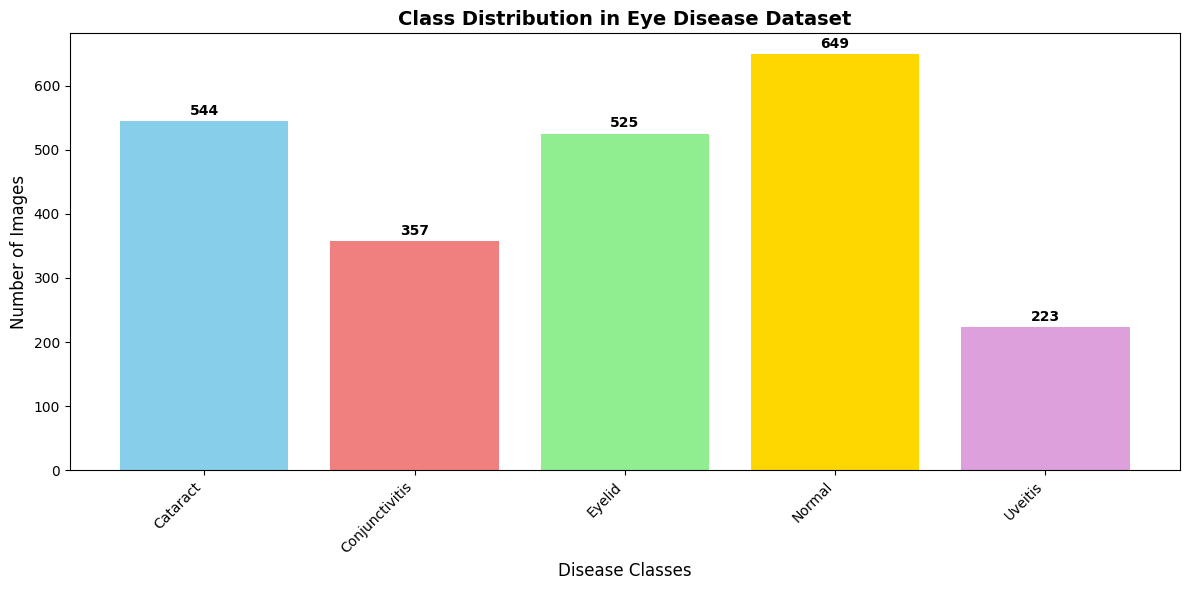

Creating data splits with oversampling...
Loading all images for oversampling...
Loading Cataract images...


Processing Cataract: 100%|██████████| 544/544 [00:01<00:00, 330.01it/s]


Loading Conjunctivitis images...


Processing Conjunctivitis: 100%|██████████| 357/357 [00:01<00:00, 337.30it/s]


Loading Eyelid images...


Processing Eyelid: 100%|██████████| 525/525 [00:01<00:00, 446.93it/s]


Loading Normal images...


Processing Normal: 100%|██████████| 649/649 [00:01<00:00, 435.85it/s]


Loading Uveitis images...


Processing Uveitis: 100%|██████████| 223/223 [00:00<00:00, 262.18it/s]


Loaded 2298 images total
Class distribution before oversampling:
  Cataract: 544 images
  Conjunctivitis: 357 images
  Eyelid: 525 images
  Normal: 649 images
  Uveitis: 223 images
Applying oversampling to get 649 samples per class...
Using manual oversampling...
Class distribution after oversampling:
  Cataract: 649 images
  Conjunctivitis: 649 images
  Eyelid: 649 images
  Normal: 649 images
  Uveitis: 649 images
Total images after oversampling: 3245
Training set: 2271 images
Validation set: 487 images
Test set: 487 images

Training set class distribution:
  Cataract: 454 images
  Conjunctivitis: 454 images
  Eyelid: 455 images
  Normal: 454 images
  Uveitis: 454 images

Validation set class distribution:
  Cataract: 97 images
  Conjunctivitis: 98 images
  Eyelid: 97 images
  Normal: 97 images
  Uveitis: 98 images

Test set class distribution:
  Cataract: 98 images
  Conjunctivitis: 97 images
  Eyelid: 97 images
  Normal: 98 images
  Uveitis: 97 images


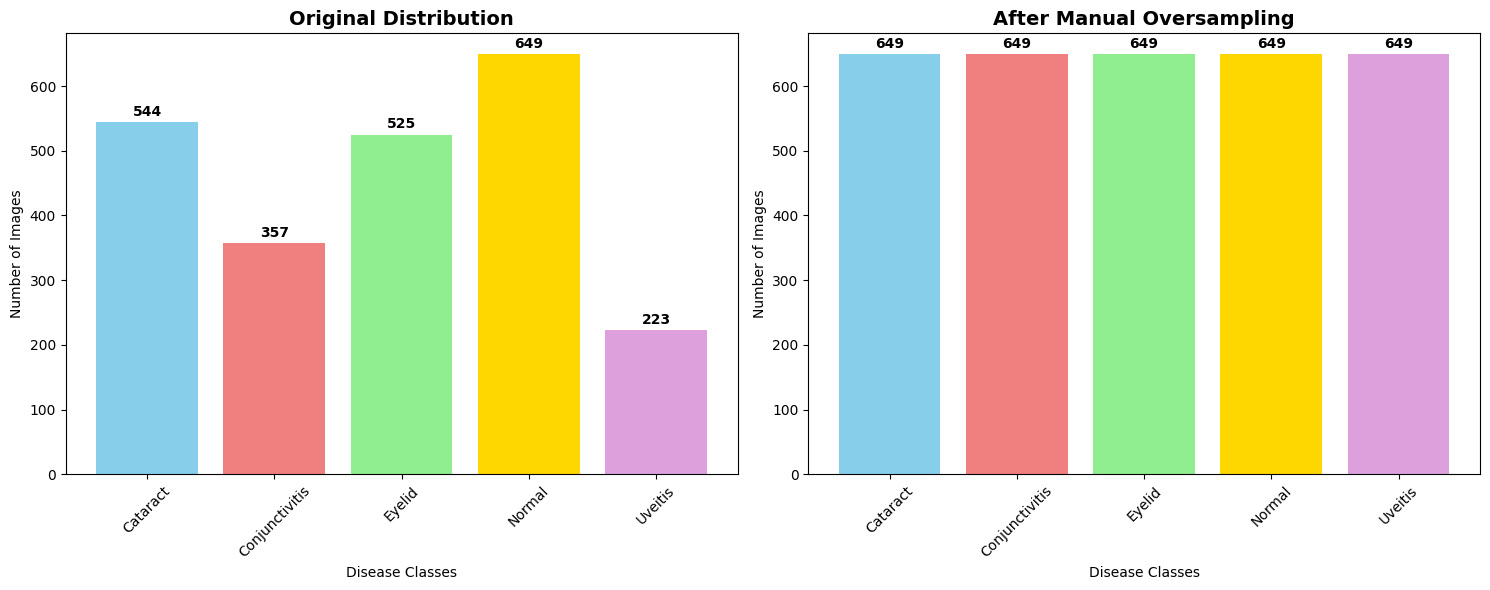

Creating data generators from arrays...
Training steps per epoch: 70
Validation steps per epoch: 15
Test steps per epoch: 15
Split information saved to data_splits/

Split Statistics:

TRAIN SET:
class_name
Cataract          454
Conjunctivitis    454
Eyelid            455
Normal            454
Uveitis           454
Name: count, dtype: int64

VALIDATION SET:
class_name
Cataract          97
Conjunctivitis    98
Eyelid            97
Normal            97
Uveitis           98
Name: count, dtype: int64

TEST SET:
class_name
Cataract          98
Conjunctivitis    97
Eyelid            97
Normal            98
Uveitis           97
Name: count, dtype: int64


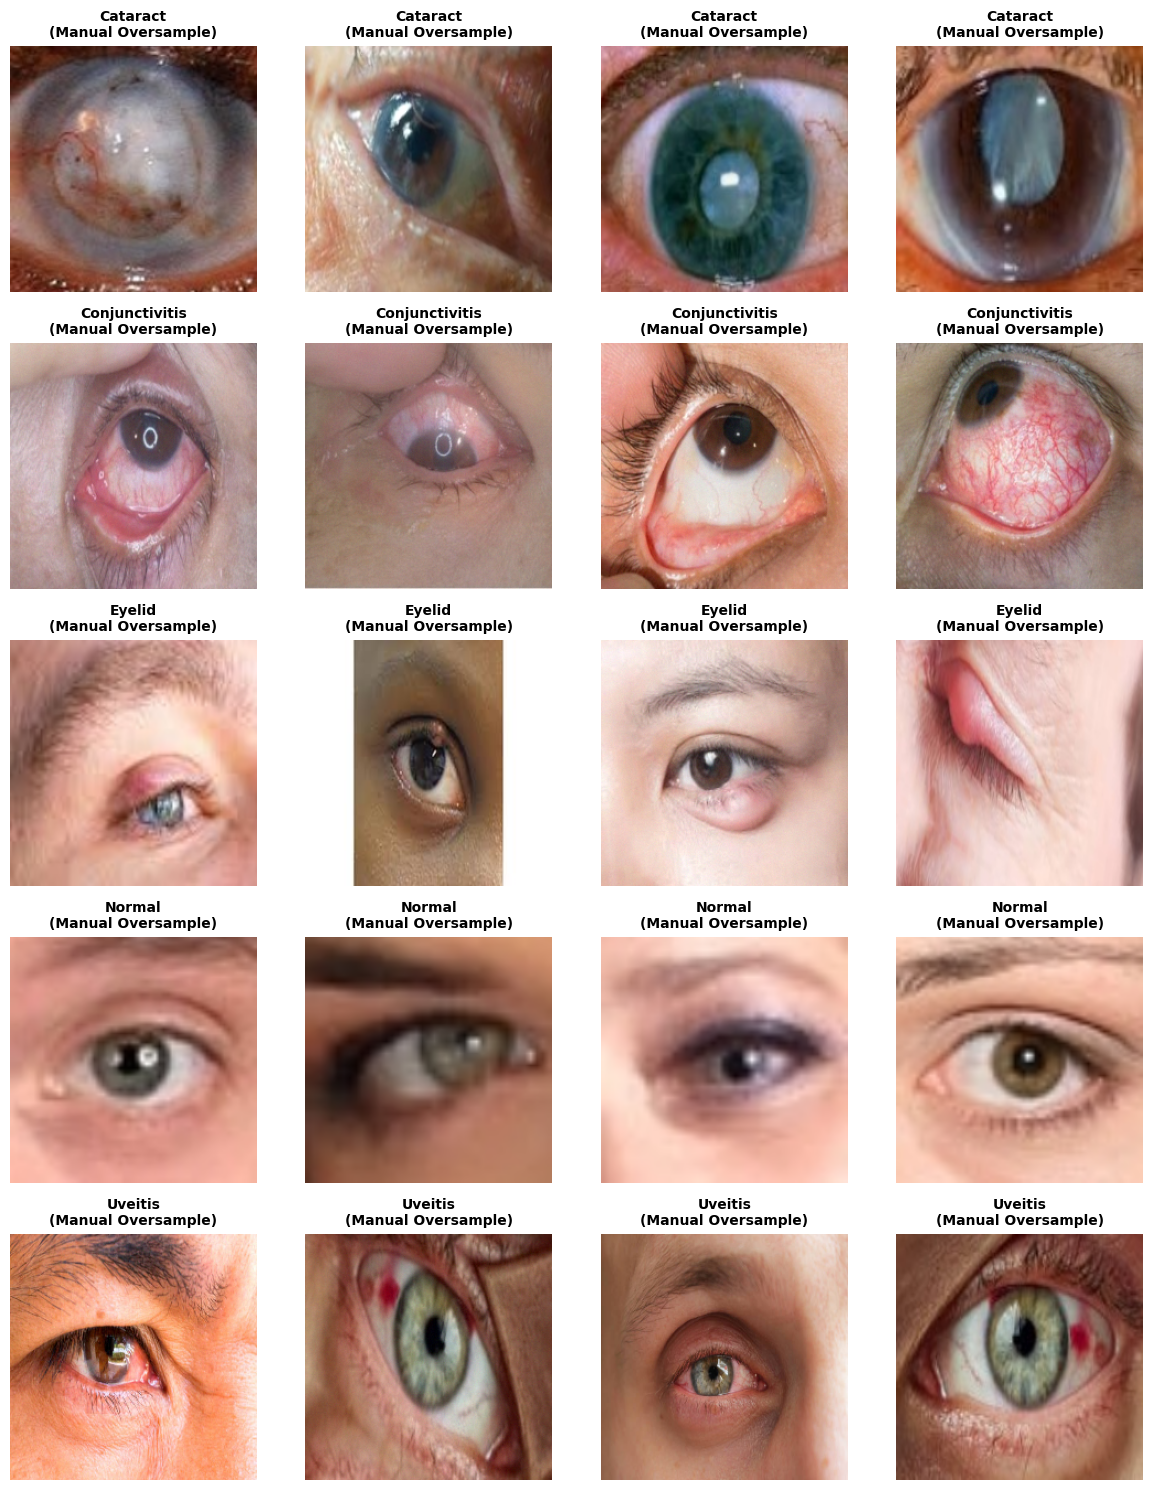

Preprocessing with Manual Oversampling completed successfully!
Manual Oversampling Results:
- Each class now has exactly 649 samples
- Total dataset size: 3245 images
- Training set: 2271 images
- Validation set: 487 images
- Test set: 487 images

Data generators ready for model training:
- train_gen: Training data generator with augmentation
- val_gen: Validation data generator
- test_gen: Test data generator
- train_steps: 70
- val_steps: 15
- test_steps: 15


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import shutil
from pathlib import Path
import random
from tqdm import tqdm
from collections import Counter

# Try to import SMOTE, with fallback to manual oversampling
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imblearn not available. Using manual oversampling instead.")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

class ManualSMOTE:
    """Manual implementation of SMOTE-like oversampling for when imblearn is not available"""
    
    def __init__(self, sampling_strategy, random_state=42, k_neighbors=5):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        np.random.seed(random_state)
    
    def fit_resample(self, X, y):
        """
        Apply manual oversampling by duplicating and slightly modifying existing samples
        """
        X_resampled = []
        y_resampled = []
        
        # Add all original samples
        X_resampled.extend(X)
        y_resampled.extend(y)
        
        # For each class, add synthetic samples
        for class_label, target_count in self.sampling_strategy.items():
            class_indices = np.where(y == class_label)[0]
            current_count = len(class_indices)
            
            if target_count > current_count:
                samples_needed = target_count - current_count
                
                # Generate synthetic samples by adding noise to existing samples
                for _ in range(samples_needed):
                    # Randomly select a sample from this class
                    idx = np.random.choice(class_indices)
                    original_sample = X[idx].copy()
                    
                    # Add small amount of Gaussian noise
                    noise = np.random.normal(0, 0.01, original_sample.shape)
                    synthetic_sample = original_sample + noise
                    
                    # Clip to valid range [0, 1]
                    synthetic_sample = np.clip(synthetic_sample, 0, 1)
                    
                    X_resampled.append(synthetic_sample)
                    y_resampled.append(class_label)
        
        return np.array(X_resampled), np.array(y_resampled)

class EyeDiseasePreprocessor:
    def __init__(self, dataset_path, sub_path=None, target_size=(224, 224), batch_size=32):
        """
        Initialize the preprocessor
        
        Args:
            dataset_path: Path to the main dataset directory
            sub_path: Path to the subdirectory containing class folders
            target_size: Target image size (height, width)
            batch_size: Batch size for data generators
        """
        self.dataset_path = Path(dataset_path)
        # Use sub_path if provided, otherwise use dataset_path
        if sub_path:
            self.data_dir = Path(sub_path)
        else:
            self.data_dir = self.dataset_path
            
        self.target_size = target_size
        self.batch_size = batch_size
        self.classes = ['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}
        
    def analyze_dataset(self):
        """Analyze the dataset structure and distribution"""
        print("Dataset Analysis:")
        print("="*50)
        print(f"Looking for classes in: {self.data_dir}")
        
        class_counts = {}
        total_images = 0
        
        for class_name in self.classes:
            class_path = self.data_dir / class_name
            print(f"Checking path: {class_path}")
            
            if class_path.exists():
                # Get all image files with various extensions
                image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.JPG', '*.JPEG', '*.PNG']
                image_count = 0
                for ext in image_extensions:
                    image_count += len(list(class_path.glob(ext)))
                    
                class_counts[class_name] = image_count
                total_images += image_count
                print(f"  {class_name}: {image_count} images")
            else:
                print(f"  Warning: {class_name} directory not found!")
                class_counts[class_name] = 0
        
        print(f"\nTotal images: {total_images}")
        print(f"Number of classes: {len(self.classes)}")
        
        # Visualize class distribution
        plt.figure(figsize=(12, 6))
        bars = plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
        plt.title('Class Distribution in Eye Disease Dataset', fontsize=14, fontweight='bold')
        plt.xlabel('Disease Classes', fontsize=12)
        plt.ylabel('Number of Images', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return class_counts
    
    def load_and_preprocess_image(self, image_path, augment=False):
        """
        Load and preprocess a single image
        
        Args:
            image_path: Path to the image file
            augment: Whether to apply augmentation
            
        Returns:
            Preprocessed image array
        """
        try:
            # Load image
            image = cv2.imread(str(image_path))
            if image is None:
                return None
            
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize image
            image = cv2.resize(image, self.target_size)
            
            # Normalize pixel values to [0, 1]
            image = image.astype(np.float32) / 255.0
            
            return image
            
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return None
    
    def load_all_images_and_labels(self):
        """
        Load all images and labels for SMOTE processing
        
        Returns:
            X: Array of flattened images
            y: Array of labels
            image_paths: Array of image paths for reference
        """
        print("Loading all images for oversampling...")
        print("="*50)
        
        all_images = []
        all_labels = []
        all_paths = []
        
        for class_name in self.classes:
            class_path = self.data_dir / class_name
            if class_path.exists():
                print(f"Loading {class_name} images...")
                
                # Get all image files
                image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.JPG', '*.JPEG', '*.PNG']
                image_paths = []
                for ext in image_extensions:
                    image_paths.extend(list(class_path.glob(ext)))
                
                # Load and process images
                for img_path in tqdm(image_paths, desc=f"Processing {class_name}"):
                    image = self.load_and_preprocess_image(img_path)
                    if image is not None:
                        # Flatten image for SMOTE
                        flattened_image = image.flatten()
                        all_images.append(flattened_image)
                        all_labels.append(self.class_to_idx[class_name])
                        all_paths.append(str(img_path))
        
        X = np.array(all_images)
        y = np.array(all_labels)
        paths = np.array(all_paths)
        
        print(f"Loaded {len(X)} images total")
        print("Class distribution before oversampling:")
        for class_name in self.classes:
            class_count = np.sum(y == self.class_to_idx[class_name])
            print(f"  {class_name}: {class_count} images")
        
        return X, y, paths
    
    def apply_oversampling(self, X, y, target_samples_per_class=649):
        """
        Apply oversampling to balance the dataset
        
        Args:
            X: Feature matrix (flattened images)
            y: Labels
            target_samples_per_class: Target number of samples per class
            
        Returns:
            X_resampled: Balanced feature matrix
            y_resampled: Balanced labels
        """
        print(f"Applying oversampling to get {target_samples_per_class} samples per class...")
        print("="*50)
        
        # Create sampling strategy
        sampling_strategy = {i: target_samples_per_class for i in range(len(self.classes))}
        
        # Apply oversampling
        if SMOTE_AVAILABLE:
            print("Using SMOTE for oversampling...")
            smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
            X_resampled, y_resampled = smote.fit_resample(X, y)
        else:
            print("Using manual oversampling...")
            manual_smote = ManualSMOTE(sampling_strategy=sampling_strategy, random_state=42)
            X_resampled, y_resampled = manual_smote.fit_resample(X, y)
        
        print("Class distribution after oversampling:")
        for class_name in self.classes:
            class_count = np.sum(y_resampled == self.class_to_idx[class_name])
            print(f"  {class_name}: {class_count} images")
        
        print(f"Total images after oversampling: {len(X_resampled)}")
        
        return X_resampled, y_resampled
    
    def reshape_images(self, X_flat):
        """
        Reshape flattened images back to original shape
        
        Args:
            X_flat: Flattened image array
            
        Returns:
            X_reshaped: Reshaped image array
        """
        return X_flat.reshape(-1, self.target_size[0], self.target_size[1], 3)
    
    def create_data_splits_with_oversampling(self, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, target_samples=649):
        """
        Create train, validation, and test splits with oversampling applied
        
        Args:
            train_ratio: Proportion of data for training
            val_ratio: Proportion of data for validation
            test_ratio: Proportion of data for testing
            target_samples: Target number of samples per class after oversampling
        """
        print("Creating data splits with oversampling...")
        print("="*50)
        
        # Verify ratios sum to 1
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
        
        # Load all images and labels
        X_flat, y, paths = self.load_all_images_and_labels()
        
        # Apply oversampling
        X_resampled_flat, y_resampled = self.apply_oversampling(X_flat, y, target_samples)
        
        # Reshape images back to original dimensions
        X_resampled = self.reshape_images(X_resampled_flat)
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_resampled, y_resampled, 
            test_size=test_ratio, 
            stratify=y_resampled, 
            random_state=42
        )
        
        # Second split: separate train and validation
        relative_val_size = val_ratio / (train_ratio + val_ratio)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, 
            test_size=relative_val_size, 
            stratify=y_temp, 
            random_state=42
        )
        
        print(f"Training set: {len(X_train)} images")
        print(f"Validation set: {len(X_val)} images")
        print(f"Test set: {len(X_test)} images")
        
        # Print class distribution for each split
        for split_name, (X_split, y_split) in [("Training", (X_train, y_train)), 
                                               ("Validation", (X_val, y_val)), 
                                               ("Test", (X_test, y_test))]:
            print(f"\n{split_name} set class distribution:")
            for class_name in self.classes:
                class_count = np.sum(y_split == self.class_to_idx[class_name])
                print(f"  {class_name}: {class_count} images")
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def create_data_generators_from_arrays(self, train_data, val_data, test_data):
        """
        Create data generators from numpy arrays
        
        Args:
            train_data: Tuple of (X_train, y_train)
            val_data: Tuple of (X_val, y_val)
            test_data: Tuple of (X_test, y_test)
            
        Returns:
            Training, validation, and test generators
        """
        print("Creating data generators from arrays...")
        print("="*50)
        
        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2],
            channel_shift_range=0.2
        )
        
        # No augmentation for validation and test
        val_test_datagen = ImageDataGenerator()
        
        X_train, y_train = train_data
        X_val, y_val = val_data
        X_test, y_test = test_data
        
        # Convert labels to categorical
        y_train_cat = to_categorical(y_train, num_classes=len(self.classes))
        y_val_cat = to_categorical(y_val, num_classes=len(self.classes))
        y_test_cat = to_categorical(y_test, num_classes=len(self.classes))
        
        # Create generators
        train_generator = train_datagen.flow(
            X_train, y_train_cat,
            batch_size=self.batch_size,
            shuffle=True
        )
        
        val_generator = val_test_datagen.flow(
            X_val, y_val_cat,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        test_generator = val_test_datagen.flow(
            X_test, y_test_cat,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        # Calculate steps per epoch
        train_steps = len(X_train) // self.batch_size
        val_steps = len(X_val) // self.batch_size
        test_steps = len(X_test) // self.batch_size
        
        print(f"Training steps per epoch: {train_steps}")
        print(f"Validation steps per epoch: {val_steps}")
        print(f"Test steps per epoch: {test_steps}")
        
        return train_generator, val_generator, test_generator, train_steps, val_steps, test_steps
    
    def save_split_info_arrays(self, train_data, val_data, test_data, output_dir='data_splits'):
        """
        Save information about the data splits from arrays
        
        Args:
            train_data: Training data tuple
            val_data: Validation data tuple
            test_data: Test data tuple
            output_dir: Directory to save split information
        """
        os.makedirs(output_dir, exist_ok=True)
        
        X_train, y_train = train_data
        X_val, y_val = val_data
        X_test, y_test = test_data
        
        # Create DataFrames for each split
        def create_dataframe(labels, split_name, start_idx=0):
            df = pd.DataFrame({
                'image_index': range(start_idx, start_idx + len(labels)),
                'label': labels,
                'class_name': [self.idx_to_class[label] for label in labels],
                'split': split_name
            })
            return df
        
        train_df = create_dataframe(y_train, 'train', 0)
        val_df = create_dataframe(y_val, 'validation', len(y_train))
        test_df = create_dataframe(y_test, 'test', len(y_train) + len(y_val))
        
        # Combine all splits
        all_splits_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
        
        # Save to CSV
        method_name = "smote" if SMOTE_AVAILABLE else "manual_oversample"
        all_splits_df.to_csv(os.path.join(output_dir, f'data_splits_{method_name}.csv'), index=False)
        train_df.to_csv(os.path.join(output_dir, f'train_split_{method_name}.csv'), index=False)
        val_df.to_csv(os.path.join(output_dir, f'val_split_{method_name}.csv'), index=False)
        test_df.to_csv(os.path.join(output_dir, f'test_split_{method_name}.csv'), index=False)
        
        print(f"Split information saved to {output_dir}/")
        
        # Print split statistics
        print("\nSplit Statistics:")
        print("="*50)
        for split_name in ['train', 'validation', 'test']:
            split_df = all_splits_df[all_splits_df['split'] == split_name]
            print(f"\n{split_name.upper()} SET:")
            print(split_df['class_name'].value_counts().sort_index())
    
    def visualize_samples_from_arrays(self, train_data, num_samples=5):
        """
        Visualize sample images from training arrays
        
        Args:
            train_data: Training data tuple
            num_samples: Number of samples to show per class
        """
        X_train, y_train = train_data
        
        fig, axes = plt.subplots(len(self.classes), num_samples, 
                                figsize=(num_samples * 3, len(self.classes) * 3))
        
        if len(self.classes) == 1:
            axes = axes.reshape(1, -1)
        
        for class_idx, class_name in enumerate(self.classes):
            # Find indices for this class
            class_indices = np.where(y_train == class_idx)[0]
            
            # Randomly sample images
            sample_indices = np.random.choice(class_indices, 
                                            min(num_samples, len(class_indices)), 
                                            replace=False)
            
            for i, idx in enumerate(sample_indices):
                image = X_train[idx]
                
                if len(self.classes) > 1:
                    ax = axes[class_idx, i]
                else:
                    ax = axes[i]
                    
                ax.imshow(image)
                method = "SMOTE" if SMOTE_AVAILABLE else "Manual Oversample"
                ax.set_title(f"{class_name}\n({method})", fontsize=10, fontweight='bold')
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def compare_distributions(self, original_counts, balanced_counts):
        """
        Compare original and balanced distributions
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Original distribution
        bars1 = ax1.bar(original_counts.keys(), original_counts.values(), 
                       color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
        ax1.set_title('Original Distribution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Disease Classes')
        ax1.set_ylabel('Number of Images')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        # Balanced distribution
        method = "SMOTE" if SMOTE_AVAILABLE else "Manual Oversampling"
        bars2 = ax2.bar(balanced_counts.keys(), balanced_counts.values(), 
                       color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
        ax2.set_title(f'After {method}', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Disease Classes')
        ax2.set_ylabel('Number of Images')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

def main():
    """Main function to run the preprocessing pipeline with oversampling"""
    
    # Configuration
    DATASET_PATH = "/kaggle/input/eye-disease-detection"
    SUB_PATH = "/kaggle/input/eye-disease-detection/Image Dataset on Eye Diseases Classification (Uveitis, Conjunctivitis, Cataract, Eyelid) with Symptoms and SMOTE Validation"
    TARGET_SIZE = (224, 224)
    BATCH_SIZE = 32
    TARGET_SAMPLES_PER_CLASS = 649
    
    # Initialize preprocessor
    preprocessor = EyeDiseasePreprocessor(
        dataset_path=DATASET_PATH,
        sub_path=SUB_PATH,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE
    )
    
    # Analyze original dataset
    original_counts = preprocessor.analyze_dataset()
    
    # Create data splits with oversampling
    train_data, val_data, test_data = preprocessor.create_data_splits_with_oversampling(
        train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, 
        target_samples=TARGET_SAMPLES_PER_CLASS
    )
    
    # Create balanced counts for comparison
    balanced_counts = {class_name: TARGET_SAMPLES_PER_CLASS for class_name in preprocessor.classes}
    
    # Compare distributions
    preprocessor.compare_distributions(original_counts, balanced_counts)
    
    # Create data generators
    train_gen, val_gen, test_gen, train_steps, val_steps, test_steps = preprocessor.create_data_generators_from_arrays(
        train_data, val_data, test_data
    )
    
    # Save split information
    preprocessor.save_split_info_arrays(train_data, val_data, test_data)
    
    # Visualize samples
    preprocessor.visualize_samples_from_arrays(train_data, num_samples=4)
    
    method = "SMOTE" if SMOTE_AVAILABLE else "Manual Oversampling"
    print(f"Preprocessing with {method} completed successfully!")
    print("="*60)
    print(f"{method} Results:")
    print(f"- Each class now has exactly {TARGET_SAMPLES_PER_CLASS} samples")
    print(f"- Total dataset size: {TARGET_SAMPLES_PER_CLASS * len(preprocessor.classes)} images")
    print(f"- Training set: {len(train_data[0])} images")
    print(f"- Validation set: {len(val_data[0])} images")
    print(f"- Test set: {len(test_data[0])} images")
    print("\nData generators ready for model training:")
    print("- train_gen: Training data generator with augmentation")
    print("- val_gen: Validation data generator")
    print("- test_gen: Test data generator")
    print(f"- train_steps: {train_steps}")
    print(f"- val_steps: {val_steps}")
    print(f"- test_steps: {test_steps}")
    
    return train_gen, val_gen, test_gen, train_steps, val_steps, test_steps, preprocessor, train_data, val_data, test_data

if __name__ == "__main__":
    train_gen, val_gen, test_gen, train_steps, val_steps, test_steps, preprocessor, train_data, val_data, test_data = main()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import torch.nn.functional as F
from tqdm import tqdm
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Try to import SMOTE, with fallback to manual oversampling
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imblearn not available. Using manual oversampling instead.")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class ManualSMOTE:
    """Manual implementation of SMOTE-like oversampling for when imblearn is not available"""
    
    def __init__(self, sampling_strategy, random_state=42, k_neighbors=5):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        np.random.seed(random_state)
    
    def fit_resample(self, X, y):
        """Apply manual oversampling by duplicating and slightly modifying existing samples"""
        X_resampled = []
        y_resampled = []
        
        # Add all original samples
        X_resampled.extend(X)
        y_resampled.extend(y)
        
        # For each class, add synthetic samples
        for class_label, target_count in self.sampling_strategy.items():
            class_indices = np.where(y == class_label)[0]
            current_count = len(class_indices)
            
            if target_count > current_count:
                samples_needed = target_count - current_count
                
                # Generate synthetic samples by adding noise to existing samples
                for _ in range(samples_needed):
                    # Randomly select a sample from this class
                    idx = np.random.choice(class_indices)
                    original_sample = X[idx].copy()
                    
                    # Add small amount of Gaussian noise
                    noise = np.random.normal(0, 0.01, original_sample.shape)
                    synthetic_sample = original_sample + noise
                    
                    # Clip to valid range [0, 1]
                    synthetic_sample = np.clip(synthetic_sample, 0, 1)
                    
                    X_resampled.append(synthetic_sample)
                    y_resampled.append(class_label)
        
        return np.array(X_resampled), np.array(y_resampled)

class EyeDiseaseDataset(Dataset):
    """Custom Dataset class for eye disease images"""
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert numpy array to PIL Image for transforms
        if isinstance(image, np.ndarray):
            # Convert from float [0,1] to uint8 [0,255]
            image = (image * 255).astype(np.uint8)
            image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

class EfficientNetB3Model(nn.Module):
    """EfficientNet-B3 model for eye disease classification"""
    
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super(EfficientNetB3Model, self).__init__()
        
        # Load pre-trained EfficientNet-B3
        self.backbone = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        
        # Get the number of features from the classifier
        num_features = self.backbone.classifier[1].in_features
        
        # Replace the classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

class EarlyStoppingCallback:
    """Early stopping callback to stop training when validation loss stops improving"""
    
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)

class EyeDiseaseTrainer:
    """Main training class for eye disease classification"""
    
    def __init__(self, dataset_path, sub_path=None, target_size=(224, 224), batch_size=32):
        self.dataset_path = Path(dataset_path)
        if sub_path:
            self.data_dir = Path(sub_path)
        else:
            self.data_dir = self.dataset_path
            
        self.target_size = target_size
        self.batch_size = batch_size
        self.classes = ['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}
        
        # Check for CUDA availability
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name(0)}")
            print(f"CUDA Version: {torch.version.cuda}")
    
    def load_and_preprocess_image(self, image_path):
        """Load and preprocess a single image"""
        try:
            # Load image
            image = cv2.imread(str(image_path))
            if image is None:
                return None
            
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize image
            image = cv2.resize(image, self.target_size)
            
            # Normalize pixel values to [0, 1]
            image = image.astype(np.float32) / 255.0
            
            return image
            
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return None
    
    def load_all_images_and_labels(self):
        """Load all images and labels for processing"""
        print("Loading all images...")
        print("="*50)
        
        all_images = []
        all_labels = []
        
        for class_name in self.classes:
            class_path = self.data_dir / class_name
            if class_path.exists():
                print(f"Loading {class_name} images...")
                
                # Get all image files
                image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.JPG', '*.JPEG', '*.PNG']
                image_paths = []
                for ext in image_extensions:
                    image_paths.extend(list(class_path.glob(ext)))
                
                # Load and process images
                for img_path in tqdm(image_paths, desc=f"Processing {class_name}"):
                    image = self.load_and_preprocess_image(img_path)
                    if image is not None:
                        all_images.append(image)
                        all_labels.append(self.class_to_idx[class_name])
        
        X = np.array(all_images)
        y = np.array(all_labels)
        
        print(f"Loaded {len(X)} images total")
        return X, y
    
    def apply_oversampling(self, X, y, target_samples_per_class=649):
        """Apply oversampling to balance the dataset"""
        print(f"Applying oversampling to get {target_samples_per_class} samples per class...")
        
        # Flatten images for SMOTE
        X_flat = X.reshape(X.shape[0], -1)
        
        # Create sampling strategy
        sampling_strategy = {i: target_samples_per_class for i in range(len(self.classes))}
        
        # Apply oversampling
        if SMOTE_AVAILABLE:
            print("Using SMOTE for oversampling...")
            smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
            X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y)
        else:
            print("Using manual oversampling...")
            manual_smote = ManualSMOTE(sampling_strategy=sampling_strategy, random_state=42)
            X_resampled_flat, y_resampled = manual_smote.fit_resample(X_flat, y)
        
        # Reshape images back to original dimensions
        X_resampled = X_resampled_flat.reshape(-1, self.target_size[0], self.target_size[1], 3)
        
        return X_resampled, y_resampled
    
    def prepare_data(self, target_samples=649):
        """Prepare and split the data"""
        # Load all images and labels
        X, y = self.load_all_images_and_labels()
        
        # Apply oversampling
        X_resampled, y_resampled = self.apply_oversampling(X, y, target_samples)
        
        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.15, stratify=y_resampled, random_state=42
        )
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42  # 0.176 ≈ 0.15/0.85
        )
        
        print(f"Training set: {len(X_train)} images")
        print(f"Validation set: {len(X_val)} images")
        print(f"Test set: {len(X_test)} images")
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def get_transforms(self):
        """Get data transforms for training and validation"""
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(p=0.1),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        return train_transform, val_transform
    
    def create_data_loaders(self, train_data, val_data, test_data):
        """Create PyTorch data loaders"""
        train_transform, val_transform = self.get_transforms()
        
        # Create datasets
        train_dataset = EyeDiseaseDataset(train_data[0], train_data[1], train_transform)
        val_dataset = EyeDiseaseDataset(val_data[0], val_data[1], val_transform)
        test_dataset = EyeDiseaseDataset(test_data[0], test_data[1], val_transform)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, 
                                num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, 
                              num_workers=4, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, 
                               num_workers=4, pin_memory=True)
        
        return train_loader, val_loader, test_loader
    
    def train_epoch(self, model, train_loader, criterion, optimizer, scheduler=None):
        """Train for one epoch"""
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        train_bar = tqdm(train_loader, desc='Training')
        for images, labels in train_bar:
            images, labels = images.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * correct_predictions / total_samples:.2f}%'
            })
        
        if scheduler:
            scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / total_samples
        
        return epoch_loss, epoch_acc
    
    def validate_epoch(self, model, val_loader, criterion):
        """Validate for one epoch"""
        model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc='Validation')
            for images, labels in val_bar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                
                # Update progress bar
                val_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100 * correct_predictions / total_samples:.2f}%'
                })
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct_predictions / total_samples
        
        return epoch_loss, epoch_acc
    
    def train_model(self, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, patience=10):
        """Train the complete model"""
        print("Initializing model...")
        model = EfficientNetB3Model(num_classes=len(self.classes)).to(self.device)
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        # Early stopping
        early_stopping = EarlyStoppingCallback(patience=patience)
        
        # Training history
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        
        print(f"Starting training for {num_epochs} epochs...")
        print("="*60)
        
        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 40)
            
            # Train
            train_loss, train_acc = self.train_epoch(model, train_loader, criterion, optimizer, scheduler)
            
            # Validate
            val_loss, val_acc = self.validate_epoch(model, val_loader, criterion)
            
            # Update history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            # Print epoch results
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
            
            # Early stopping check
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                break
        
        print("\nTraining completed!")
        return model, history
    
    def evaluate_model(self, model, test_loader):
        """Evaluate the model on test set"""
        model.eval()
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc='Testing')
            for images, labels in test_bar:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions, average='weighted')
        
        print(f"\nTest Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions, 
                                  target_names=self.classes))
        
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.classes, yticklabels=self.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return accuracy, f1
    
    def plot_training_history(self, history):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot loss
        ax1.plot(history['train_loss'], label='Training Loss', color='blue')
        ax1.plot(history['val_loss'], label='Validation Loss', color='red')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracy
        ax2.plot(history['train_acc'], label='Training Accuracy', color='blue')
        ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, model, filepath='/kaggle/working/eye_disease_efficientnet_b3.pth'):
        """Save the trained model"""
        torch.save({
            'model_state_dict': model.state_dict(),
            'classes': self.classes,
            'class_to_idx': self.class_to_idx,
            'idx_to_class': self.idx_to_class
        }, filepath)
        print(f"Model saved to {filepath}")

def main():
    """Main training pipeline"""
    # Configuration
    DATASET_PATH = "/kaggle/input/eye-disease-detection"
    SUB_PATH = "/kaggle/input/eye-disease-detection/Image Dataset on Eye Diseases Classification (Uveitis, Conjunctivitis, Cataract, Eyelid) with Symptoms and SMOTE Validation"
    TARGET_SIZE = (224, 224)
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    PATIENCE = 10
    TARGET_SAMPLES_PER_CLASS = 649
    
    # Initialize trainer
    trainer = EyeDiseaseTrainer(
        dataset_path=DATASET_PATH,
        sub_path=SUB_PATH,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE
    )
    
    print("Eye Disease Classification Training")
    print("="*60)
    print(f"Model: EfficientNet-B3")
    print(f"Device: {trainer.device}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Max Epochs: {NUM_EPOCHS}")
    print(f"Early Stopping Patience: {PATIENCE}")
    print("="*60)
    
    # Prepare data
    train_data, val_data, test_data = trainer.prepare_data(target_samples=TARGET_SAMPLES_PER_CLASS)
    
    # Create data loaders
    train_loader, val_loader, test_loader = trainer.create_data_loaders(
        train_data, val_data, test_data
    )
    
    # Train model
    model, history = trainer.train_model(
        train_loader, val_loader, 
        num_epochs=NUM_EPOCHS, 
        learning_rate=LEARNING_RATE,
        patience=PATIENCE
    )
    
    # Plot training history
    trainer.plot_training_history(history)
    
    # Evaluate on test set
    test_accuracy, test_f1 = trainer.evaluate_model(model, test_loader)
    
    # Save model
    trainer.save_model(model)
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Test F1-Score: {test_f1:.4f}")
    print("Model saved as 'eye_disease_efficientnet_b3.pth'")
    print("="*60)
    
    return model, trainer, history

if __name__ == "__main__":
    model, trainer, history = main()

Using device: cuda
GPU: Tesla P100-PCIE-16GB
CUDA Version: 12.4
Eye Disease Classification Training
Model: EfficientNet-B3
Device: cuda
Batch Size: 32
Learning Rate: 0.0001
Max Epochs: 50
Early Stopping Patience: 10
Loading all images...
Loading Cataract images...


Processing Cataract: 100%|██████████| 544/544 [00:05<00:00, 96.63it/s] 


Loading Conjunctivitis images...


Processing Conjunctivitis: 100%|██████████| 357/357 [00:04<00:00, 87.31it/s] 


Loading Eyelid images...


Processing Eyelid: 100%|██████████| 525/525 [00:04<00:00, 118.88it/s]


Loading Normal images...


Processing Normal: 100%|██████████| 649/649 [00:05<00:00, 128.18it/s]


Loading Uveitis images...


Processing Uveitis: 100%|██████████| 223/223 [00:02<00:00, 93.41it/s] 


Loaded 2298 images total
Applying oversampling to get 649 samples per class...
Using manual oversampling...
Training set: 2272 images
Validation set: 486 images
Test set: 487 images
Initializing model...


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 222MB/s]


Starting training for 50 epochs...

Epoch 1/50
----------------------------------------


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.78it/s, Loss=1.3693, Acc=74.90%]


Train Loss: 1.3578, Train Acc: 0.4793
Val Loss: 0.7954, Val Acc: 0.7490
Learning Rate: 0.000100

Epoch 2/50
----------------------------------------


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s, Loss=0.5334, Acc=94.03%]


Train Loss: 0.4908, Train Acc: 0.8398
Val Loss: 0.1955, Val Acc: 0.9403
Learning Rate: 0.000100

Epoch 3/50
----------------------------------------


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.66it/s, Loss=0.2794, Acc=93.21%]


Train Loss: 0.2520, Train Acc: 0.9102
Val Loss: 0.1913, Val Acc: 0.9321
Learning Rate: 0.000099

Epoch 4/50
----------------------------------------


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.40it/s, Loss=0.1344, Acc=96.50%]


Train Loss: 0.1485, Train Acc: 0.9454
Val Loss: 0.0846, Val Acc: 0.9650
Learning Rate: 0.000098

Epoch 5/50
----------------------------------------


Training:   0%|          | 0/71 [00:00<?, ?it/s]


KeyboardInterrupt: 